In [2]:
from BorderModel import BorderData
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from dbhelper import pd_query

In [65]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            minofday,
            newyears,
            us_mlk,
            us_washington,
            us_memorial,
            us_independence,
            us_columbus,
            us_veterans,
            us_thanksgiving,
            xmas,
            ca_goodfriday,
            ca_victoria,
            ca_canada,
            ca_civic,
            ca_thanksgiving,
            ca_boxing,
            ca_family
        from crossingdata c
        join datefeatures d on c.date = d.date
        left join publicholiday h on c.date::timestamp::date = h.date
        where
            valid=1
            and waittime is not null
            and crossing_id = 1
            and (minute = 0 or minute = 30)
        order by c.date;
        '''

df30 = pd_query(query)

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

OOB:  0.546244041955
** MSE for last cv fold **
Baseline :  107.994317561
Model    :  109.687603207
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.132664130971
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.275634370349


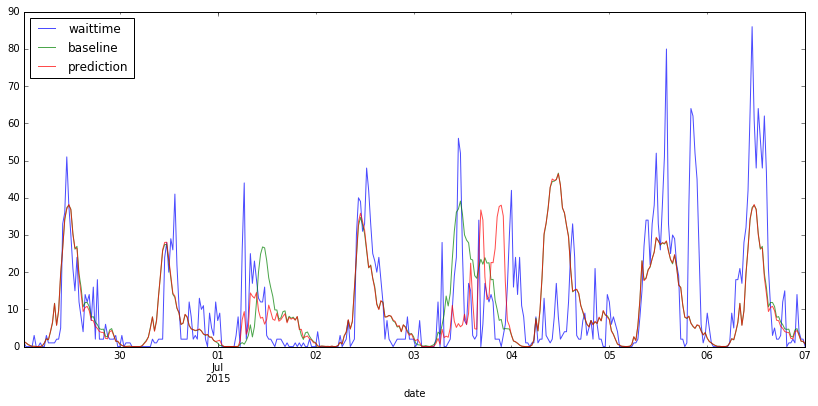

In [110]:
df = df30.drop(['dayofmonth', 'week', 'month'], axis=1)
data = BorderData(df)

model = RandomForestRegressor(n_jobs=-1, oob_score=True)
params = {'n_estimators': [100]}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

In [111]:
grid.best_score_

0.48237473100221218

In [112]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'dayofweek' 'year' 'ca_goodfriday' 'us_veterans' 'ca_boxing'
 'newyears' 'us_memorial' 'us_washington' 'us_thanksgiving'
 'us_independence' 'ca_civic' 'ca_canada' 'us_mlk' 'xmas' 'ca_victoria'
 'us_columbus' 'ca_thanksgiving' 'ca_family']
[0.67857511238828283, 0.1474327578743283, 0.11425624733667428, 0.016049996035166717, 0.0085004815825393317, 0.0061453055250929901, 0.0046171723409689372, 0.0040938874600669221, 0.0036194482140348171, 0.0026418068789925771, 0.0025242427379157007, 0.0024039568195011324, 0.0023783391695381567, 0.0020258211263601334, 0.0019697494285649876, 0.0017308101319875905, 0.0010348649499843765, 0.0, 0.0]


## RF still seems to want to fit to 2014 average

OOB:  0.825458603343
** MSE for last cv fold **
Baseline :  107.994317561
Model    :  136.014071542
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  -0.0755078923405
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.0741353735209


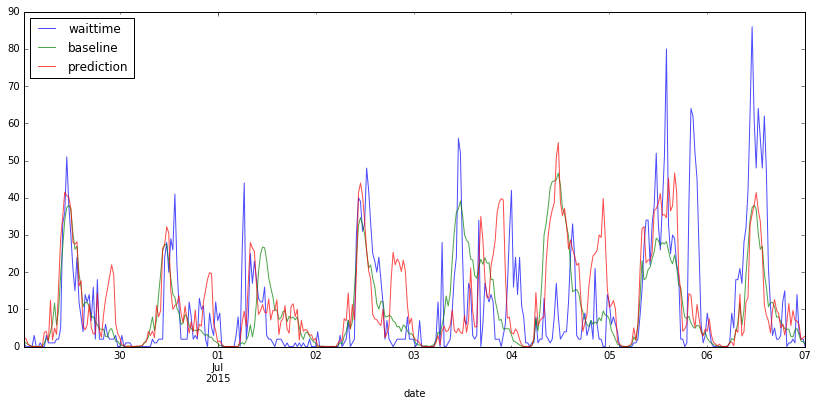

In [105]:
df = df30.drop(['dayofmonth', 'month'], axis=1)
data = BorderData(df)

model = RandomForestRegressor(n_jobs=-1, oob_score=True)
params = {'n_estimators': [100]}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

In [106]:
grid.best_score_

0.1391889117848589

## Significant increase in OOB score, but compared to 2015, model is worse

## Try RF keeping all features

OOB:  0.84700911459
** MSE for last cv fold **
Baseline :  107.994317561
Model    :  125.801021593
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.00525004468817
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.163714398773


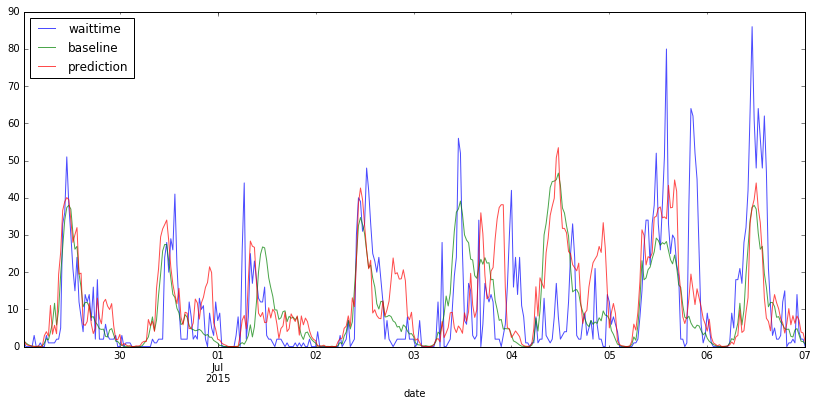

In [87]:
data = BorderData(df30)

model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

## Try GBR

** MSE for last cv fold **
Baseline :  107.994317561
Model    :  113.112612923
** R^2 for last cv fold **
Baseline :  0.146053496169
Model    :  0.105581455336
** Explained variance for last cv fold **
Baseline :  0.282901756576
Model    :  0.24813108736


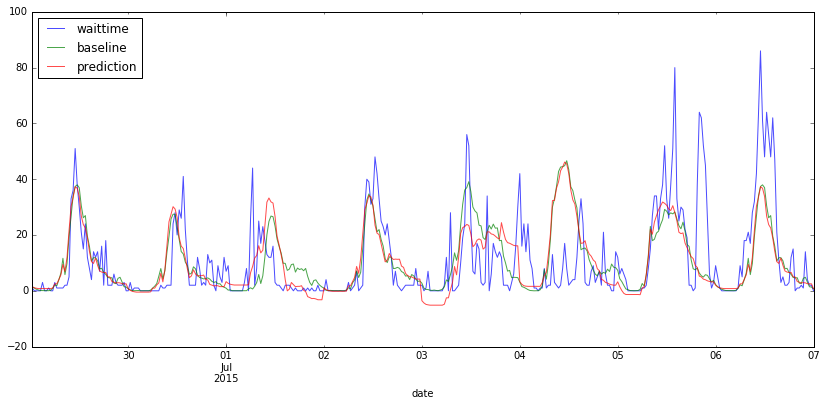

In [76]:
model = GradientBoostingRegressor(subsample=.2, n_estimators=300)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid.best_estimator_)
data.print_metrics(grid.best_estimator_)
data.plot('6/29/15', '7/7/15');

In [77]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'year' 'dayofweek' 'ca_goodfriday' 'us_veterans' 'newyears'
 'us_washington' 'us_memorial' 'ca_boxing' 'us_mlk' 'us_independence'
 'ca_civic' 'us_thanksgiving' 'ca_canada' 'ca_victoria' 'xmas'
 'us_columbus' 'ca_thanksgiving' 'ca_family']
[0.52149672394911184, 0.17625532129909371, 0.15577166563149764, 0.022321991411032905, 0.018481895225525864, 0.016255501690918567, 0.012943000676807837, 0.012469160459851934, 0.012131667367216036, 0.0095025740461531401, 0.0086207194676627651, 0.0071187178176277321, 0.0070140640401349314, 0.0065048691844593045, 0.0053657776837319942, 0.0047961910307674866, 0.0029501590184062877, 0.0, 0.0]


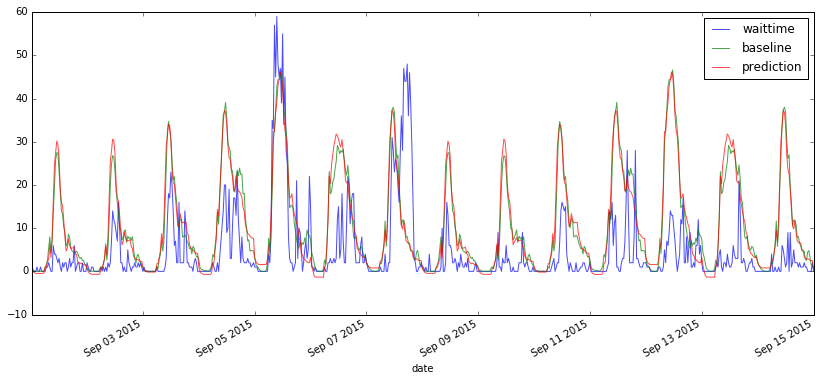

In [85]:

data.plot('9/1/15', '9/15/15');

## GBR predicts values under zero.  These can be clipped as a post-processing step